# Segment and analyze whole spheroids for calculating throughput  
Data: id551_MDCK_unit_acousticon_sheathon_01_200Hz_405_250mW_488_150mW_488_reconstructed_cropped.tif

## Libraries

In [1]:
import numpy as np
import pandas as pd
import tifffile

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.transform import rescale
from skimage.measure import regionprops_table, marching_cubes, mesh_surface_area
from skimage.color import label2rgb
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border

import pyclesperanto_prototype as cle

In [2]:
cle.select_device('GTX')

<NVIDIA GeForce GTX TITAN X on Platform: NVIDIA CUDA (1 refs)>

## Functions

In [3]:
def segment(data, sigma_spot_detection = 8, sigma_outline = 2):
    '''
    Segment spheroids

    data: name of the input data
    sigma_spot_detectio: sigma of Gaussian filter for detecting spheroids
    sigma_outline: sigmae of Gaussian fileter for detecting edges of spheroids
    '''
    img = tifffile.imread(f'../result/{data}.tif')
    img = rescale(img, 0.5, anti_aliasing=True)
    img = img[:, 10:630, :]
    img_gpu = cle.push(img)
    segmented = cle.voronoi_otsu_labeling(img_gpu, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)
    
    return cle.pull(segmented)

In [4]:
def calculate_props(segmented, scale=(None, None, None)):
    '''
    Calculate morphological properties of spheroids

    segmented: label image after segmentation
    scale: pixel resolution in um scale
    '''
    segmented = clear_border(segmented) # remove objects on the edge
    segmented = remove_small_objects(segmented, min_size=100) # remove small objects
    
    # calculate properties
    props = pd.DataFrame(regionprops_table(label_image=segmented, intensity_image=intensity_img,
                         properties=('label', 'area', 'solidity', 'bbox'), spacing=scale))
    props = props.rename(columns={'label':'Label', 'area': 'Volume', 'solidity': 'Solidity'})
    
    return props

In [5]:
def filter(segmented, props, data, volume_thresh=20000, solidity_thresh=0.8):
    '''
    Filter out spheroids without beads

    segmented: label image after segmentation
    props: calculated properties
    data: name of the input data
    volume_thresh: threshold value of volume
    splidity_thresh: threshold value of solidity
    '''
    props_filtered = props[(props['Volume']>volume_thresh)&(props['Solidity']>solidity_thresh)]
    retained_label = props_filtered['Label'].values
    label_img = np.where(np.isin(segmented, retained_label), segment, 0)
    np.save(f'../result/{data}_segmented_spheroids.npy', label_img)

## Analysis

In [6]:
data = 'id551_MDCK_unit_acousticon_sheathon_01_200Hz_405_250mW_488_150mW_488_reconstructed_cropped'

In [7]:
res_segment = segment(data='id551_MDCK_unit_acousticon_sheathon_01_200Hz_405_250mW_488_150mW_488_reconstructed_cropped')


size: 100


In [8]:
np.unique(res_segment)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121], dtype=uint32)

In [9]:
# spatial resolution in um scale
scale = np.repeat(0.295*4, 3)

In [10]:
res_props = calculate_props(res_segment, scale=scale)

In [15]:
res_props

,Label,Volume,Solidity,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5
0,9,14583.552032,0.880993,39,495,11,63,527,39
1,10,58445.934304,0.882220,29,326,2,72,363,55
2,11,23574.223136,0.578432,32,454,8,66,491,50
3,12,16827.933744,0.647531,35,181,19,67,211,57
4,14,38834.704352,0.612617,26,357,21,74,400,66
...,...,...,...,...,...,...,...,...,...
87,106,108849.226968,0.777005,29,462,402,73,537,454
88,107,34411.662208,0.845505,32,166,413,68,201,451
89,108,47743.223856,0.771793,33,421,406,71,457,456
90,109,533.985400,0.887978,72,259,435,81,268,444


In [14]:
# number of spheroids measured in one second
len(res_props[(res_props['Volume']>20000)&(res_props['Solidity']>0.8)])

37

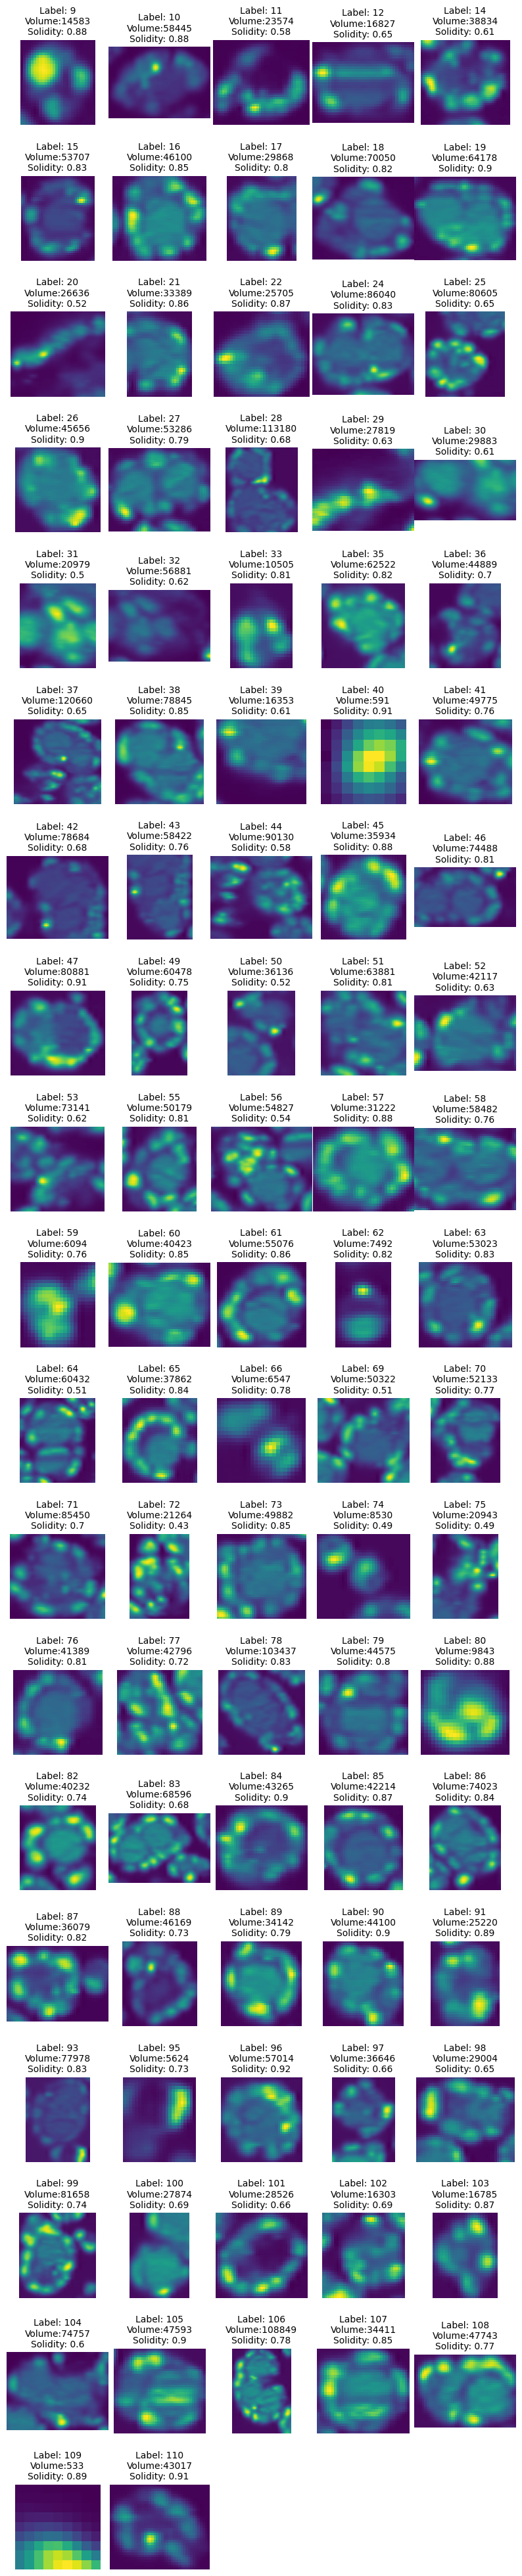

In [17]:
img = tifffile.imread(f'../result/{data}.tif')
img = rescale(img, 0.5, anti_aliasing=True)
img = img[:, 10:630, :]

n = len(res_props)

plt.figure(figsize=(10, 50))
for i in range(n):
    plt.subplot(int(np.ceil(n/5)), 5, i+1)
    plt.imshow(img[50, int(res_props.iloc[i, :]['bbox-1']):int(res_props.iloc[i, :]['bbox-4']), int(res_props.iloc[i, :]['bbox-2']):int(res_props.iloc[i, :]['bbox-5'])])
    plt.axis('off')
    plt.title('Label: '+str(int(res_props.iloc[i, :]['Label']))+'\nVolume:'+str(int(res_props.iloc[i, :]['Volume']))+'\nSolidity: '+str(np.round(res_props.iloc[i, :]['Solidity'], 2)), size=10)
plt.subplots_adjust(wspace=0, hspace=0.6)

In [18]:
filter(res_segment, res_props, data)